<a name="top"></a>
# Benjamin Mitchell
## `11/22/2020`
## Homework #13 - Working with Jupyter Notebooks!!!

___
<a name="grd"></a>
## ***Grade***



___
<a name="toc"></a>
### Table of Contents:
0. [ Grade](#grd)
1. [ Notebook Description](#dic)
2. [ Estimation Explanation](#espn)
4. [ Python Code(s)](#cod)
3. [ My Little Predictions](#mlp)
5. [ Map Code(s)](#map)
6. [ Final Map Image](#fap)

___
<a name="dic"></a>
## Notebook Description

`
This is a professional Jupyter Notebook that predicts the future flow(s) of a USGS Stream Gage, number '09506000'.  The dataset used starts from 1989-01-01 and goes until this past Saturday 2020-11-21.  Two different kinds of autoregressive models where use in this analysis.  Both models where created using python functions and are described in the coding section of this notebook.
`

~ Thank You and Enjoy!

___
<a name="espn"></a>
## Estimation Explanation

`
For my 2-week forecast this week, I went ahead and used my 'mono' autoregressive model instead of my 'poly' because the difference is so slight, and I seemed to have better luck with my single lagged time model than my double lagged time model.  In the end game, luck can play a huge role!  For my 16-week forecast I went with the same function I always do but this time I decided to use a correction factor for fun.  Help my 16-week forecasts and change it up a bit.
`

___
<a name="cod"></a>
## My Python Code(s):
1.1 [ Imports and Functions](#iaf)

1.2 [ Getting Flow Data](#gfd)

1.3 [ Data Frame Creation](#dfc)

1.4 [ Creating Imputs for AR's](#arm)

1.5 [ Running the AR's](#mod)

1.6 [ Correction Factor for 16-Weeks](#cor)

1.7 [ Ploting Time!!!](#plt)

___
<a name="iaf"></a>
### Getting Started - All My Imports and Functions

#### My Import(s)

This is where I have collected all my 'Imports' to allow my functions and models to run properly.
___
Back to [ top](#top).

In [70]:
# import io, os, sys, types
# from IPython import get_ipython
# from nbformat import read
# from IPython.core.interactiveshell import InteractiveShell
# import Mitchell_eval_functions as ef

In [71]:
# Import the modules we will use
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import json
import urllib.request as req
import urllib
# import Mitchell_eval_functions as ef
import dataretrieval.nwis as nwis

#### My Functions
This is where I have collected and defined all my 'Functions' to allow my model to run properly.
___
Back to [ top](#top).

In [72]:
# Building a function for our Linear Regression Model
def mono_reg_mod(test_weeks):
    """Linear Regression Model data being offset only once.
    test weeks = natural log streamflow laged by 1 week (x values)
    test weeks = natural log streamflow (y values)
    """
    reg_model = LinearRegression()
    x_val_model1 = test_weeks['log_flow_tm1'].values.reshape(-1, 1)  # Testing values
    y_val_model1 = test_weeks['log_flow'].values  # Testing values
    reg_model.fit(x_val_model1, y_val_model1)  # Fit linear model
    coeff_det1 = np.round(reg_model.score(x_val_model1, y_val_model1), 7)  # r^2
    b = np.round(reg_model.intercept_, 7)  # Intercept
    m = np.round(reg_model.coef_, 7)  # Slope
    q_pred_mono = reg_model.predict(test_weeks['log_flow_tm1'].values.reshape(-1,1))
    print('coefficient of determination:', np.round(coeff_det1, 7))
    # Intercept and the slope (Final equation) y= mx + b
    print('Final equation is y1 = :', m[:1], 'x + ', b)
    return(b,m,reg_model,coeff_det1,q_pred_mono)

# Building a function for our Linear Regression Model
def poly_reg_mod(test_weeks):
    """Linear Regression Model with data being offset on two separate occasions.
    test weeks = natural log of streamflow laged by 1 & 2 weeks (x values)
    test weeks = natural log of streamflow (y values)
    """
    poly_model = LinearRegression()
    x_val_model2 = test_weeks[['log_flow_tm1', 'log_flow_tm2']]  # Testing values
    y_val_model2 = test_weeks['log_flow']  # Testing values
    poly_model.fit(x_val_model2, y_val_model2)  # Fit linear model
    coeff_det2 = np.round(poly_model.score(x_val_model2, y_val_model2), 7)  # r^2
    c = np.round(poly_model.intercept_, 7)  # Intercept
    a = np.round(poly_model.coef_, 7)  # Slope(s)
    q_pred_poly = poly_model.predict(test_weeks[['log_flow_tm1', 'log_flow_tm2']])
    print('coefficient of determination:', np.round(coeff_det2, 7))
    # Intercept and the slope (Final equation) y= a1*x1 + a2*x2 + c
    print('Final equation is y2 = :', a[:1], 'x1 + ', a[1:2], 'x2 + ', c)
    return(c,a,poly_model,coeff_det2,q_pred_poly)

In [73]:
# Building a function to produce our two week flow predictions
# using linaral model1 with only one data offsets
def flow_predic_mono(b, m, num_of_weeks, week_b4, forecast_weeks):
    """This function produces predicted flow values using coefficients provided
    by an Liner Autoregressive Model with only one data offset.
    'b' is the y-intersept and 'm' is the slope.
    'num_of_weeks' is how many weeks you would like to loop the model for.
    'week_b4' is the natural log flow of a known flow and
    'forecast_weeks' is a list of dates that you are predicting for.
    """
    week_b4_i = week_b4
    pred_i = np.zeros((num_of_weeks, 1))
    for i in range(1, num_of_weeks + 1):
            log_flow_pred_i = b + m[:1] * week_b4_i
            flow_pred_i = math.exp(log_flow_pred_i)
            pred_i[i-1] = flow_pred_i
            week_b4_i = log_flow_pred_i
    flow_predictions_mono = pd.DataFrame(pred_i, index = forecast_weeks,
                                        columns=["Predicted_Flows_Mono:"])
    return flow_predictions_mono

# Building a function to produce our two week flow predictions
# using linaral model2 with multiple data offsets
def flow_predic_poly(c, a, num_of_weeks, week_b4, forecast_weeks):
    """This function produces predicted flow values using coefficients provided
    by an Liner Autoregressive Model with two different data offsets.
    'c' is the y-intersept and 'a' is a list of two slopes provided by the model.
    'num_of_weeks' is how many weeks you would like to loop the model for.
    'week_b4' is the natural log flow of a known flow and
    'forecast_weeks' is a list of dates that you are predicting for.
    """
    week_b4_i = week_b4
    pred_i = np.zeros((num_of_weeks, 1))
    for i in range(1, num_of_weeks + 1):
            log_flow_pred_i = c + a[1] * week_b4_i + a[0] * (week_b4_i)
            flow_pred_i = math.exp(log_flow_pred_i)
            pred_i[i-1] = flow_pred_i
            week_b4_i = log_flow_pred_i
    flow_predictions_poly = pd.DataFrame(pred_i, index = forecast_weeks,
                                         columns=["Predicted_Flows_Poly:"])
    return flow_predictions_poly

___
<a name="gfd"></a>
### Getting The Data - URL creation

This is how to collect the data from the USGS Website using URL creation and the USG's API format.
___
Back to [ top](#top).

In [74]:
# Find the data you want to use from the USGS Website
# Site number for Verde River Near Camp Verde
site = '09506000'
start = '1989-01-01'
end = '2020-11-21' # Saturday before perdiction
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" + site + \
      "&referred_module=sw&period=&begin_date=" + start + "&end_date=" + end
print(url)

https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=09506000&referred_module=sw&period=&begin_date=1989-01-01&end_date=2020-11-21


___
<a name="dfc"></a>
### Data Frame Creation - Manipulation of USGS Data into a workable dataset

Here is where the data frames are created and manipulated into a workable data frame for further manipulation.
___
Back to [ top](#top).

In [75]:
# Read the data from dictionary into a pandas dataframe
flow_data = pd.read_table(url, skiprows=30,
                              names=['agency_cd', 'site_no',
                                     'datetime', 'flow', 'code'],
                              parse_dates=['datetime'])

# Expand the dates to year month day
flow_data['year'] = pd.DatetimeIndex(flow_data['datetime']).year
flow_data['month'] = pd.DatetimeIndex(flow_data['datetime']).month
flow_data['day'] = pd.DatetimeIndex(flow_data['datetime']).day
flow_data['dayofweek'] = pd.DatetimeIndex(flow_data['datetime']).dayofweek

# Aggregate flow values to weekly
flow_weekly = flow_data.resample("W", on='datetime').mean()

# As an added bonus I am taking the natural log of the data
# because it fits the model better with all data included
flow_weekly.insert(2, 'log_flow', np.log(flow_weekly['flow']), True)
# print(flow_weekly)
# print(type(flow_weekly['log_flow']))

___
<a name="arm"></a>
### Time for the Autoregressive Model(s) - Creating Imputs

Here is the creation of the imputs, from the pandas dataframes above, needed to run the two Autoregressive Model functions 'mono_reg_mod' and 'poly_reg_mod'.  The function titled 'mono_reg_mod' use just one lagging timestep of the natural log flow data.  The function titled 'poly_reg_mod' uses two lagging timesteps of the natural log flow data.
___
Back to [ top](#top).

In [76]:
# Step 1: setup the arrays you will build your model on
# This is an autoregressive model so we will be building
# it based on the lagged timeseries
shifts = [1, 2]
flow_weekly['log_flow_tm1'] = flow_weekly['log_flow'].shift(shifts[0]) # Flow lag 1week
flow_weekly['log_flow_tm2'] = flow_weekly['log_flow'].shift(shifts[1]) # Flow lag 2weeks
print('Shfiting the data by', shifts, 'weeks.')

Shfiting the data by [1, 2] weeks.


In [77]:
# Step 2: Pick what portion of the time series you want to use as training data
# here I'm grabbing the weeks for our training period.
# LC nice  job defining these as variables -- one suggestion would be to move user defined variables to the top
trainstart = '2016-01-01'
trainend = '2019-12-31'
print('trainstart', trainstart)
print('trainend', trainend)

# Note1 - dropping the first two weeks since they wont have lagged data
# to go with them
train = flow_weekly[trainstart:trainend][['log_flow',
                                          'log_flow_tm1', 'log_flow_tm2']]
test = flow_weekly[trainend:][['log_flow',
                               'log_flow_tm1', 'log_flow_tm2']]
# print(train)
# print(test)

trainstart 2016-01-01
trainend 2019-12-31


___
<a name="mod"></a>
### Time for the Autoregressive Model(s) - Running both Models

Here is where both models are run and the outputs are labeled respectively.  The erquations for each models is shown below this next cell.  As you can see, the coefficient of determination for the poly AR model shows very little improvement on the mono AR model.
___
Back to [ top](#top).

In [78]:
# Step 3a: Fit a linear regression model using sklearn, 1 variable
b, m, reg_model1, coeff_det1, q_pred_mono = mono_reg_mod(train)
print('\n')
# Step 3b: Fit a linear regression model using sklearn, 2 variables
c, a, reg_model2, coeff_det2, q_pred_poly = poly_reg_mod(train)

coefficient of determination: 0.776843
Final equation is y1 = : [0.8851347] x +  0.5907568


coefficient of determination: 0.7774437
Final equation is y2 = : [0.9313922] x1 +  [-0.0524192] x2 +  0.6221032


___
<a name="mlp"></a>
## My Little Predictions
___
Back to [ top](#top).

In [79]:
# Getting our two week predictions!

# Defining prediction weeks for our 2 week flow predictions.
# These are the weeks we will be predicting for our 2 week predictions.
forecast_week_1_2 = ['2020-11-30','2020-12-07']

# Geting last weeks flow
week_before_flow = flow_weekly['log_flow'].tail(1)
print("Last weeks's flow was", math.exp(week_before_flow),'cfs!', '\n')

# Finding next weeks and next next weeks flows using both models outputs
# The number chosen for the function named "flow_predic_mono" and "flow_predic_poly",
#  was "2". This is because we want to predict next weeks flow and next next weeks flow.
flow_predic_mono2 = flow_predic_mono(b, m, 2, week_before_flow, forecast_week_1_2)
flow_predic_poly2 = flow_predic_poly(c, a, 2, week_before_flow, forecast_week_1_2)
print(flow_predic_mono2, '\n')
print(flow_predic_poly2)

Last weeks's flow was 155.83333333333331 cfs! 

            Predicted_Flows_Mono:
2020-11-30             157.529607
2020-12-07             159.046435 

            Predicted_Flows_Poly:
2020-11-30             157.566991
2020-12-07             159.106749


In [80]:
# Getting our sixteen week predictions!

# Defining prediction weeks for our 16 week flow predictions.
# These are the weeks we will be predicting for our 16 week predictions.
forecast_week_1_thru_16 = ['2020-08-22','2020-08-30','2020-09-06','2020-09-13',
                           '2020-09-20','2020-09-27','2020-10-04','2020-10-11',
                           '2020-10-18','2020-10-25','2020-11-01','2020-11-08',
                           '2020-11-15','2020-11-22','2020-11-29','2020-12-06']

# Getting the first weekly average flow of the semester!
week_start_flow = flow_weekly.loc['2020-08-16'][['log_flow']]
print("First flow of the semester was", math.exp(week_start_flow),'cfs!', '\n')

# Running the functions for 16 weeks out
flow_predic_mono16 = flow_predic_mono(b, m, 16, week_start_flow, forecast_week_1_thru_16)
flow_predic_poly16 = flow_predic_poly(c, a, 16, week_start_flow, forecast_week_1_thru_16)

print(flow_predic_mono16, '\n')
print(flow_predic_poly16)

First flow of the semester was 34.99999999999999 cfs! 

            Predicted_Flows_Mono:
2020-08-22              42.002063
2020-08-30              49.360048
2020-09-06              56.941368
2020-09-13              64.617859
2020-09-20              72.271704
2020-09-27              79.799425
2020-10-04              87.114090
2020-10-11              94.146025
2020-10-18             100.842371
2020-10-25             107.165849
2020-11-01             113.093016
2020-11-08             118.612289
2020-11-15             123.721899
2020-11-22             128.427933
2020-11-29             132.742534
2020-12-06             136.682317 

            Predicted_Flows_Poly:
2020-08-22              42.400415
2020-08-30              50.186900
2020-09-06              58.203488
2020-09-13              66.300761
2020-09-20              74.343256
2020-09-27              82.214195
2020-10-04              89.817824
2020-10-11              97.079808
2020-10-18             103.946207
2020-10-25             1

___
<a name="cor"></a>
### Correction Factors for 16-Week Flow Predictions

Making better use of the 16-week predictions.
___
Back to [ top](#top).

In [81]:
Corr_fac_mono = float(flow_weekly['flow'].tail(2).head(1)) / float(flow_predic_mono16.loc['2020-11-15'])
print(Corr_fac_mono)
Corr_fac_poly = float(flow_weekly['flow'].tail(2).head(1)) / float(flow_predic_poly16.loc['2020-11-15'])
print(Corr_fac_poly)

Corr_predic_mono16 = flow_predic_mono16 * Corr_fac_mono
print(Corr_predic_mono16)
Corr_predic_poly16 = flow_predic_poly16 * Corr_fac_poly
print(Corr_predic_poly16)

1.278212331820926
1.2455232521072725
            Predicted_Flows_Mono:
2020-08-22              53.687555
2020-08-30              63.092622
2020-09-06              72.783159
2020-09-13              82.595345
2020-09-20              92.378583
2020-09-27             102.000609
2020-10-04             111.350305
2020-10-11             120.338610
2020-10-18             128.897962
2020-10-25             136.980709
2020-11-01             144.556888
2020-11-08             151.611691
2020-11-15             158.142857
2020-11-22             164.158167
2020-11-29             169.673145
2020-12-06             174.709023
            Predicted_Flows_Poly:
2020-08-22              52.810703
2020-08-30              62.508951
2020-09-06              72.493797
2020-09-13              82.579139
2020-09-20              92.596254
2020-09-27             102.399692
2020-10-04             111.870188
2020-10-11             120.915158
2020-10-18             129.467418
2020-10-25             137.482738
2020-11-01 

___
<a name="plt"></a>
### Plotting Time!!!

Here are all the plots created from my code. I have created several plots and I will explain them each in detail below.
___
Back to [ top](#top).

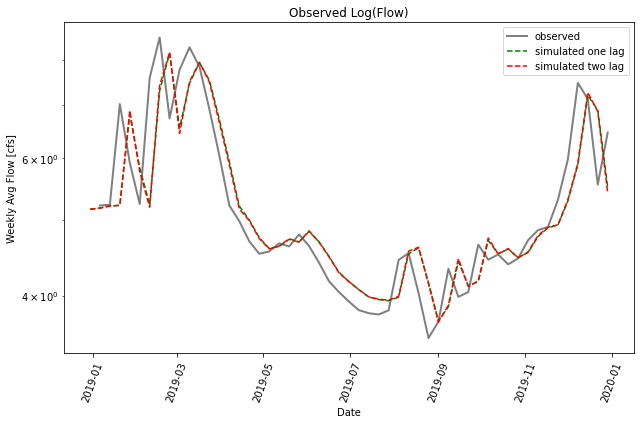

In [82]:
# Line  plot comparison of predicted (1, 2) lagging and observed flows
fig1, ax = plt.subplots()
ax.plot(train['2019-01-01':'2019-12-31'][['log_flow']], color='grey', linewidth=2,
        label='observed')
ax.plot(train.index[156:209], q_pred_mono[156:209], color='g', linestyle='--',
        label='simulated one lag')
ax.plot(train.index[156:209], q_pred_poly[156:209], color='r', linestyle='--',
        label='simulated two lag')
ax.set(title="Observed Log(Flow)", xlabel="Date", ylabel="Weekly Avg Flow [cfs]",
       yscale='log')
ax.legend()
ax.tick_params(axis='x', labelrotation=70)
fig1.set_size_inches(9, 6)
fig1.patch.set_facecolor('xkcd:white')
plt.tight_layout()
# An example of saving your figure to a file
fig1.savefig("graphs/Observed_Log_Flow_Sim.png")

[Fig. 1] For this plot, I wanted to compare my 'mono' function AR model to the 'poly' function AR model and as you can see the simulated log plot for both are right on top of each other.  You would need to zoom in more to see the data closer to see that these two lines are slightly off from one another.  I checked the 'q_pred_mono' and 'q_pred_poly' data frames and their values are different, be it slightly.

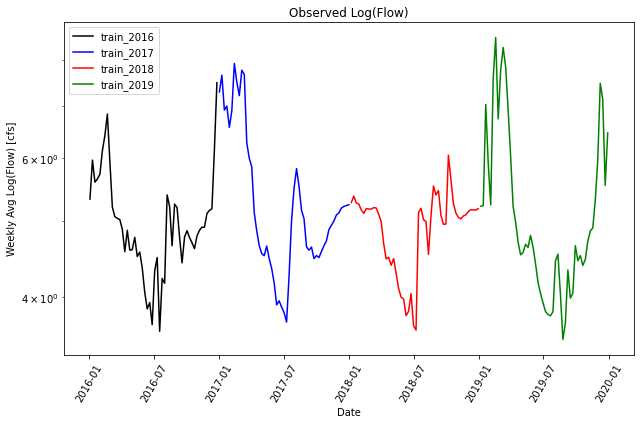

In [83]:
# Timeseries of the natural log of observed flow values
# Note that date is the index for the dataframe so it will
# automatically treat this as our x axis unless we tell it otherwise

fig2, ax = plt.subplots()
ax.plot(train['2016-01-01':'2016-12-31'][['log_flow']], 'k', label='train_2016')
ax.plot(train['2017-01-01':'2017-12-31'][['log_flow']], 'b', label='train_2017')
ax.plot(train['2018-01-01':'2018-12-31'][['log_flow']], 'r', label='train_2018')
ax.plot(train['2019-01-01':'2019-12-31'][['log_flow']], 'g', label='train_2019')
ax.set(title="Observed Log(Flow)", xlabel="Date",
       ylabel="Weekly Avg Log(Flow) [cfs]", yscale='log')
ax.legend()
plt.xticks(rotation = 60)
fig2.set_size_inches(9, 6)
fig2.patch.set_facecolor('xkcd:white')
plt.tight_layout()
fig2.savefig("graphs/Observed_Log_Flow_Train.png")

[Fig. 2] For this plot, my real intention was to compare the flows over different years; 2016, 2017, 2018, 2019.  I found it initially difficult but found a way later one.  This graph shows the four different years I used in my training periods for the models.

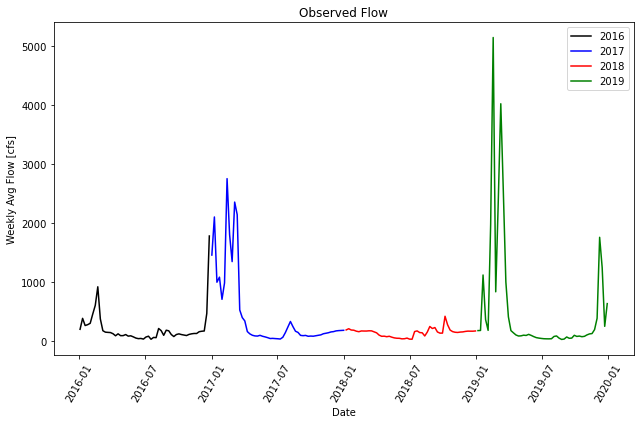

In [84]:
# Timeseries of the real observed flow values
# Note that date is the index for the dataframe so it will
# automatically treat this as our x axis unless we tell it otherwise

fig3, ax = plt.subplots()
ax.plot(flow_weekly['2016-01-01':'2016-12-31'][['flow']], 'k', label='2016')
ax.plot(flow_weekly['2017-01-01':'2017-12-31'][['flow']], 'b', label='2017')
ax.plot(flow_weekly['2018-01-01':'2018-12-31'][['flow']], 'r', label='2018')
ax.plot(flow_weekly['2019-01-01':'2019-12-31'][['flow']], 'g', label='2019')
ax.set(title="Observed Flow", xlabel="Date",
       ylabel="Weekly Avg Flow [cfs]")
ax.legend()
plt.xticks(rotation = 60)
fig3.set_size_inches(9, 6)
fig3.patch.set_facecolor('xkcd:white')
plt.tight_layout()
fig3.savefig("graphs/Observed_Flow_Train.png")

[Fig. 3] This plot is similar to the last one, but this is plotting the original data before converted to the natural log values used in the AR models.

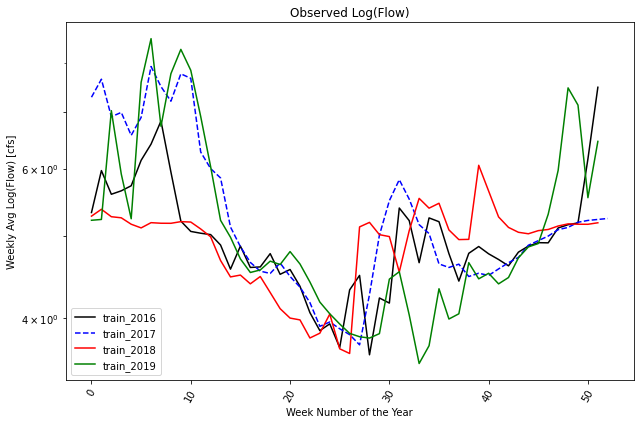

In [85]:
# Timeseries of observed flow values
# Note that date is the index for the dataframe so it will
# automatically treat this as our x axis unless we tell it otherwise

# print(len(train['2016-01-01':'2016-12-31'][['log_flow']]))
# print(len(train['2017-01-01':'2017-12-31'][['log_flow']]))
# print(len(train['2018-01-01':'2018-12-31'][['log_flow']]))
# print(len(train['2019-01-01':'2019-12-31'][['log_flow']]))

x = np.arange(0,52,1)
x_ly = np.arange(0,53,1)

fig4, ax = plt.subplots()
ax.plot(x, train['2016-01-01':'2016-12-31'][['log_flow']], 'k', label='train_2016')
ax.plot(x_ly, train['2017-01-01':'2017-12-31'][['log_flow']], '--b', label='train_2017')
ax.plot(x, train['2018-01-01':'2018-12-31'][['log_flow']], 'r', label='train_2018')
ax.plot(x, train['2019-01-01':'2019-12-31'][['log_flow']], 'g', label='train_2019')
ax.set(title="Observed Log(Flow)", xlabel="Week Number of the Year",
       ylabel="Weekly Avg Log(Flow) [cfs]",
       yscale='log')
ax.legend()
plt.xticks(rotation = 60)
plt.yticks(np.arange(4, 8, step=1))
fig4.set_size_inches(9, 6)
fig4.patch.set_facecolor('xkcd:white')
plt.tight_layout()
fig4.savefig("graphs/Observed_Log_Flow_Comparison.png")

[Fig. 4] For this plot, I wanted to compare the four different years used in my AR models.  The blue dotted line is the year '2017' which was a leap year, so the data set was longer by one extra week.  There was a total of 52 weeks of data for each year, but '2017' had 53 weeks of data.

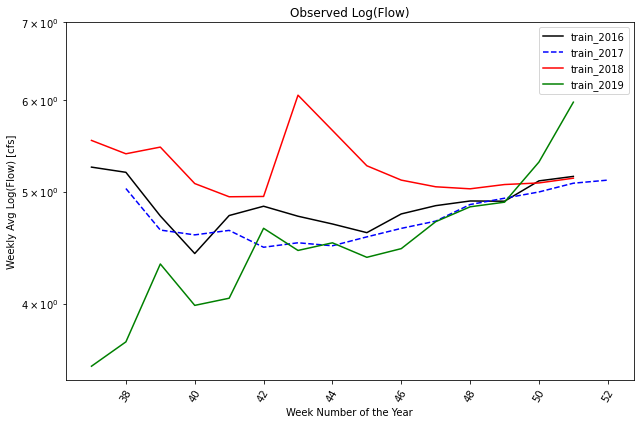

In [86]:
# Timeseries of observed flow values
# Note that date is the index for the dataframe so it will
# automatically treat this as our x axis unless we tell it otherwise

# print(len(train['2016-01-01':'2016-12-31'][['log_flow']]))
# print(len(train['2017-01-01':'2017-12-31'][['log_flow']]))
# print(len(train['2018-01-01':'2018-12-31'][['log_flow']]))
# print(len(train['2019-01-01':'2019-12-31'][['log_flow']]))

x = np.arange(37,52,1)
x_ly = np.arange(38,53,1)

fig5, ax = plt.subplots()
ax.plot(x, train['2016-08-22':'2016-12-06'][['log_flow']], 'k', label='train_2016')
ax.plot(x_ly, train['2017-08-22':'2017-12-06'][['log_flow']], '--b', label='train_2017')
ax.plot(x, train['2018-08-22':'2018-12-06'][['log_flow']], 'r', label='train_2018')
ax.plot(x, train['2019-08-22':'2019-12-06'][['log_flow']], 'g', label='train_2019')
ax.set(title="Observed Log(Flow)", xlabel="Week Number of the Year",
       ylabel="Weekly Avg Log(Flow) [cfs]",
       yscale='log')
ax.legend()
plt.xticks(rotation = 60)
plt.yticks(np.arange(4, 8, step=1))
fig5.set_size_inches(9, 6)
fig5.patch.set_facecolor('xkcd:white')
plt.tight_layout()
fig5.savefig("graphs/Observed_Log_Flow_Comparison_Dates.png")

[Fig. 5] For this plot, I wanted to compare the four different years used in my AR models.  This plot is zoomed in on the sixteen weeks we are trying to predict the flows for.  The blue dotted line is the year '2017' which was a leap year, so the data set was longer by one extra week.  There was a total of 52 weeks of data for each year, but '2017' had 53 weeks of data.  Therefore, it looks longer by comparison.  Also, I wanted to average each year and try predicting the 16 weeks that way.  Maybe another correction factor?  I have an idea for the next homework assignment.

___
<a name="map"></a>
## Call me the Cartographer - My Map

Here is the map I created.  The data for the map was saved locally to my computer and could not be uploaded so I have the map produced being called in another later part of the code called 'Final Map Image'.  Please go there to see the map!  For this map, I used data from the USGS, USDA Forest Service, and from the DataGov website for the map of Arizona.
___
Back to [ top](#top).

In [87]:
# Additional Packages to add for the map
import matplotlib as mpl
import geopandas as gpd
import fiona
from shapely.geometry import Point
import contextily as ctx
from pprint import pprint

In [88]:
# 1) Gauges II USGS stream gauge dataset:
# Download here:
# https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder

# Reading it using geopandas
file = os.path.join('../../../../HAS-Tools-Fall2020_local/USGS/gagesII_9322_point_shapefile',
                    'gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)

# Zoom  in and just look at AZ
# gages.columns
# gages.STATE.unique()
gages_az=gages[gages['STATE']=='AZ']
# gages_az.shape

In [89]:
# 2) USDA Forest Service for the National Forests:
# Download here:
# https://www.fs.usda.gov/coronado
# https://data.fs.usda.gov/geodata/edw/datasets.php

# Reading it using geopandas
file = os.path.join('../../../../HAS-Tools-Fall2020_local/USDA_Forest_Service/S_USA.AdministrativeForest',
                    'S_USA.AdministrativeForest.shp')
forest = gpd.read_file(file)
# print(forest.head())

forests_az = ['Kaibab National Forest', 'Prescott National Forest',
              'Coconino National Forest', 'Tonto National Forest',
              'Apache-Sitgreaves National Forests', 'Coronado National Forest']
forest_az=forest[forest['FORESTNAME'].isin(forests_az)]
# forest_az.shape
# print(forest_az.head())

In [90]:
# 3) The State of Arizona
# Download here:
# https://repository.arizona.edu/handle/10150/188734

file = os.path.join('../../../../HAS-Tools-Fall2020_local/DataGov/tl_2016_04_cousub',
                    'tl_2016_04_cousub.shp')
fiona.listlayers(file)
az = gpd.read_file(file)
# az.shape
# print(az.head())

In [91]:
# 4) WBD 20201002 for AZ
# Download here:
# https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products
# https://viewer.nationalmap.gov/basic/?basemap=b1&category=nhd&title=NHD%20View

# Example reading in a geodataframe
# Watershed boundaries for the lower colorado 
file = os.path.join('../../../../HAS-Tools-Fall2020_local/USGS/WBD_15_HU2_GDB',
                    'WBD_15_HU2_GDB.gdb')
fiona.listlayers(file)
HUC6 = gpd.read_file(file, layer="WBDHU6")

In [92]:
# 5) Add some important points
# UA:  32.22877495, -110.97688412
# Stream gauge:  34.44833333, -111.7891667
UofA_np = np.array([[-110.97688412, 32.22877495]])

Gage_np = np.array([[-111.7891667, 34.44833333]])

#make these into spatial features
UofA_geom = [Point(xy) for xy in UofA_np]
Gage_geom = [Point(xy) for xy in Gage_np]
UofA_geom
Gage_geom

#mape a dataframe of these points
UofA = gpd.GeoDataFrame(UofA_geom, columns= ['geometry'],
                        crs=HUC6.crs)

Gage = gpd.GeoDataFrame(Gage_geom, columns= ['geometry'],
                        crs=HUC6.crs)

In [93]:
# To fix this we need to re-project
forest_az_proj = forest_az.to_crs(gages_az.crs)
HUC6_proj = HUC6.to_crs(gages_az.crs)
az_proj = az.to_crs(gages.crs)
UofA_proj = UofA.to_crs(gages_az.crs)
Gage_proj = Gage.to_crs(gages_az.crs)

C:\Users\Yoko\miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Yoko\miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Yoko\miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making 

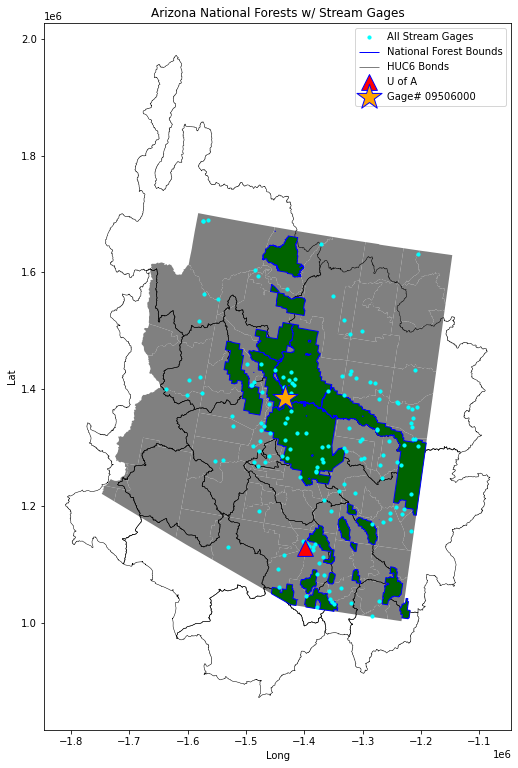

In [94]:
# Time to Plot
fig6, ax = plt.subplots(figsize=(10, 10))
gages_az.plot(ax=ax, label='All Stream Gages', color='cyan', markersize=10,
              zorder=3)
forest_az_proj.boundary.plot(ax=ax, label='National Forest Bounds',
                             facecolor='darkgreen', edgecolor='blue',
                             linewidth=1, zorder=2)
HUC6_proj.boundary.plot(ax=ax, label='HUC6 Bonds', color=None,
                        edgecolor='black', linewidth=0.5, zorder=1)
az_proj.plot(ax=ax, label='Arizona', color='grey', zorder=0)
UofA_proj.plot(ax=ax, label='U of A', color='red', edgecolor='blue', marker='^',
               markersize=250, zorder=4)
Gage_proj.plot(ax=ax, label='Gage# 09506000', color='orange', edgecolor='blue', marker='*',
               markersize=700, zorder=5)
ax.set_title('Arizona National Forests w/ Stream Gages')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
ax.legend()
fig6.set_size_inches(13, 13)
fig6.patch.set_facecolor('xkcd:white')
plt.show()

fig6.savefig("graphs/Arizona_National_Forests_w_Stream_Gages.png")

___
<a name="fap"></a>
## Final Map Image
___
Back to [ top](#top).

![My_Map](graphs/Arizona_National_Forests_w_Stream_Gages.png "My_Map")
